# MCMC

## Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

### Bayesian modelling

You should be familiar with Bayes' rule:

$$ p(h|d)=\frac{p(d|h) \times p(h)}{p(d)} $$

or:

$$ p(h|d)=\frac{p(d|h) \times p(h)}{ \int p(d|h) \times p(h) \,dh } $$

where $p(d) = \int p(d|h) \times p(h)$

* $p(h|d)$: The posterior; the probability of the hypothesis (e.g. that a parameter has a certain value) given the data
* $p(d|h)$: The likelihood of observing/generating the data given the hypothesis
* $p(h)$:   The prior probability of the hypothesis
* $p(d)$:   The probability of observing the data under all hypothesis

#### It is $p(d)$ that makes this equation so difficult to solve in high dimensions (number of parameters to estimate)

We are left in the following situation:

We have a distribution function

$$ p(x) = \frac{1}{nc}f(x) $$

where $f(x)$ is easy to compute but $nc$, the normalising constant is very hard. Aside from bayesian models, this arises in two other contexts: energy based models and directed graphical models

### Bayesian linear regression

#### Generate some data

The natural process that generates this data is of course unknown. However because we need some data to test it upon we're going to have generate some. This is a very simple example, we simply generate some data from the linear relationship $y=mx+c+\varepsilon$ where $\varepsilon$ is drawn from $N(\mu,\sigma)$

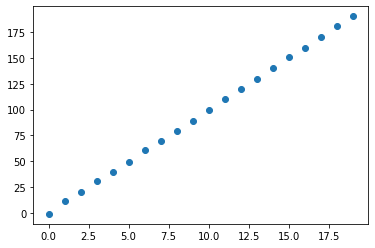

In [2]:
def generate_linear(x_vals, m_val, c_val):
    mu = x_vals * m_val
    y = np.random.normal(loc=mu, scale=1, size=x_vals.shape[0])
    return y

# our gods eye view of the world
num_train_points = 20
gradient = 10
intercept = 0

x_data = np.arange(0,num_train_points)
y_data = generate_linear(x_data,gradient,intercept)

plt.scatter(x_data,y_data)
#plt.ylim([0, 50])

We could attempt to the above solve linear regression using the bayesian approach. In this construction the parameter of interest, the gradient $m$ becomes the hypothesis in the above equations.  

The only remaining question then becomes, what should we choose for the prior distribution for the gradient?  

From the picture above we can clearly see that the gradient is positive; this should inform our choice of prior distribution; we should expect our unknown gradient parameter to be strictly positive

One choice for the prior distribution might be the gamma distribution

### The Gamma distribution

We have a few requirements for our prior distribution:

* It should produce samples that are strictly positive (positive gradient)
* The gradient looks steep, not as low as 1 but not for example 20, but we should leave room for other values incase our guess is wrong

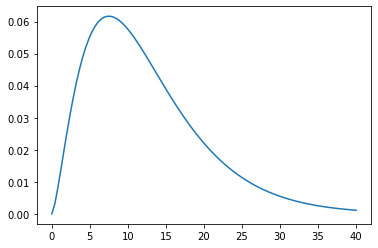

In [3]:
x = np.linspace (0, 40, 100) 
y = gamma.pdf(x, a=2.5, scale=5)

plt.plot(x, y)

plt.show()

The plot of the prior distribution for the gradient. All values are positive and the support covers gradient values we think are most likely with high density

### Dealing with $p(d)$

We've now specified our model for the data. But we still don't have a way with deal with the $p(d)$, the high dimensional integral on the bottom of bayes rule. There are essentially four ways forward:

**1. Use a conjugage prior**


Some combinations of prior and likelihood result in a posterior function (e.g. the distribution of a parameter) that is of the same form as the prior (e.g. the beta-binomial model). This means that you have an analytical form of the posterior without any hard maths.

**2. Approximate the posterior**


Techniques such as variational inference construct an analytical approximation to the posterior function. We choose a variational distribution of a simple form (e.g. a gaussian) and find the parameters of this distribution that minimises the distance to the true posterior. This can be done using the machinary of AD. VB provides a exact solution that is an approximation.


**3. Sample from the posterior**


Finally we can attempt to sample direction from the posterior without ever finding an analytical form, or an approximation thereof. We construct an empirical approximation to the posterior. This is the family that MCMC and ABC fall into.



**MCMC is asymptotically exact; VI is not.** In the limit, MCMC will exactly approximate the target distribution. VI comes without warranty.


**MCMC is computationally expensive**. In general, VI is faster.


When we value precision of our estimates, MCMC wins. If we can tolerate sacrificing accuracy for speed VI is a natural choice. Bayesian DNN are fit with VI, not MCMC!

### MCMC

#### 10k foot view

We shall use MCMC to sample from the posterior, without ever algebraically evaluating it.

#### The key idea

MCMC is the combination of markov chains and monte carlo methods. The basic idea is to increase sample efficiency by using the last sample to figure out where to go next in the distribution. Methods like accept-reject sampling throw away the information from the previous sampling event and so become very inefficient.

So, **the next sample depends only on the previous sample**. This is the exact same philosohpy as a Markov chain.


So how do we construct this chain? Well the idea behind all MCMC is to construct a Markov chain that has the same stationary distribution as the target density (for us this is the posterior function). Exactly how the chain is constructed differs from method to method, but this is the key idea

#### Detailed balance

A markov chain is entirely described by its transition probabilities.

The detailed balance equation of a markov chain checks to make sure that the transition probabalities proposed by the particular method results in a stationary distribution that is the target distribution (our posterior).

So, let's pretend that we've come up with some method for generating transition probalities. We'll call this function $T$. 

The detailed balance equation states that if:

$$ p(x)T(y|x) = p(y)T(x|y) $$

is true then $p(x)$ is the stationary distribution of our markov chain.  Let's explore this a little bit more. $p(x)$ is our posterior function that we wish to sample from and x and y are any arbitrary pair of numbers on the x axis. This equation says that the probability of being in state x and moving to state y is the same as being in state y and moving to state x.

How does this equation show that p(x) must be the stationary distribution? Let's sum over the $x$ on each side:

$$ \sum_x p(x)T(y|x) = \sum_x p(y)T(x|y) $$

$$ \sum_x p(x)T(y|x) =  p(y) \sum_x T(x|y) $$

$$ \sum_x p(x)T(y|x) =  p(y) \times 1 $$ (dot product)

$$ \textbf{p}\textbf{T} = \textbf{p} $$


That is, p is unchanged by the transition matrix and thus we have reached a stationary state and p is the stationary distribution.

Perhaps you can also see, why the evidence is no longer necessary? As the evidence is constant, we can cancel it from both sides of the detailed balance equation. We'll cover this in more detail later.

#### Summary of MCMC

**What**


* We can't directly evaluate the posterior as it is too complex to figure out for interesting problems

* Instead we sample from it

* We do this by engineering a markov chain that has the same stationary distribution as the target distribution (the posterior in our case)

* When we have "burned-in" our chain enough we continue to run the markov chain and sample from it to build up our empirical distribution of the posterior

**How**

* All markov chains are completely described by their transition probabilities or transition kernel in the continuous regime

* We therefore control/engineer the markov chain by controlling the transition probabilities

* All MCMC algorithms work from this principal but the exact method for generating these transition probabilites differs from algorithm to algorithm

* If we have a particular algorithm for generating these transition probabilities, we can verify that it converges to the stationary distribution by using the detailed/global balance equation on the proposed transition probabilities

* Thus the remaining challenge is to come up with a method to generate these transition probabilities

## Metropolis hastings

Now we're going to look at a particular MCMC algorithm, metropolis hastings (MH). Let's restate the problem. 


We wish to sample from some distribution $p(x)$, but we don't know the exact form of the distribution, we only know the numerator:

$$p(x) = \frac{f(x)}{NC}$$

In our (Bayesian) case $p(x)$ is the posterior and $NC$ is the evidence:

$$ p(h|d)=\frac{p(d|h) \times p(h)}{ \int p(d|h) \times p(h) \,dh } $$


* $p(x) = p(h|d)$
* $f(x) = p(d|h) \times p(h) $
* $NC =  \int p(d|h) \times p(h) \,dh$


**Is it possible to use only f(x) to get samples from p(x) ?**

MCMC solves this problem by constructing a markov chain so that the stationary distribution of the Markov chain is the same as $p(x)$.


As we said, the key to any MCMC algorithm is designing the transition probabilites so that you end up with this desired stationary distribution. This is how MH goes about it.

### The MH algorithm

In this section we will first show the algorithm and then prove that it is correct

Explanation in words:

1. **Propose a candidate state (x-axis point) to transition to**
    - This candidate is a sample from an easy to sample distribution (e.g. a normal) E.g. $g(x_{t+1}|x_t) = \mathcal{N}(\mu,\,\sigma^{2})$
    - The mean of this distribution is the state that we're already at - this is how we enforce the Markov property
    - We can use any proposal distribution we want as long as it's support is the same as the posterior distribution
    - When we have a symetric proposal this is known as the metropolis algorithm and when it's asymetric in the more general case it's known as the MH 
    - When it's symetric we have just as much chance of going back to where we were as to jump to where we are
    
    
2. **Accept this new state with probability $A(x_t \rightarrow x_{t+1})$**
    - How do we specify this acceptance probability?
    - Well we know that the transition probability must obey the detailed balance equations...
    

**A more mathematical formulation of the above MH**:

1. Generate a candidate, $y$, $y \sim g(y|x)$ from some transition kernel, g 


2. Set $x_{t+1} = y$ with acceptance probability, $\alpha$ 

$$ \alpha (y|x) = min \left[ \frac{f(y)\times g(x|y)}{f(x)\times g(y|x)},1 \right]  $$

   Otherwise set  $x_{t+1} = x_t$
   
   
**Note that the above equations do not require $p(x)$, rather only $f(x)$**

If we were to use the full probability distribution then the normalising constant, $ p(d) = \int p(d|h) \times p(h) \,dh$ would cancel:


$$p(x) = \frac{f(x)}{NC}$$

$$ \alpha (y|x) = min \left[ \frac{\frac{f(y)}{NC}\times g(x|y)}{\frac{f(x)}{NC}\times g(y|x)},1 \right]  $$

$$ \alpha (y|x) = min \left[ \frac{f(y)\times g(x|y)}{f(x)\times g(y|x)},1 \right]  $$


Now we've seen the algorithm, you should still be asking me, "okay great but how does this MH acceptance probability result in a markov chain where the stationary distribution is $p(x)$ ?

By using the above algorithm we are making the following claim:

"The resulting Markov chain is reversible with stationary distribution p(x). We can therefore sample from $p(x)$ by running the algorithm until the chain is stationary and then using sampled points to build our empirical distribution".


We shall prove this claim using the detailed balance condition

**side note: metropolis vs MH**

In this case that the proposal function is symetric  $ g(x|y) = g(y|x)$. This means that the acceptance condition becomes:

$$ \alpha (y|x) = min \left[ \frac{f(y)}{f(x)},1 \right]  $$



### Detailed balance applied to MH

In this section we verify the claim made in the previous section, namely that xxx. We show two different ways of arriving at this result.

#### Approach 1

Let's restate the detailed balance condition

$$ p(x)T(y|x) = p(y)T(x|y) $$

Let's plug in what we have in our problem to the detailed balance equation. We know that

$$p(x) = \frac{f(x)}{NC}$$

Therefore the detailed balance condition becomes

$$ \frac{f(x)}{NC}T(y|x) = \frac{f(y)}{NC}T(x|y) $$

Looks good, what can do we about $T$?

Well, in order to transition between say $x$ and $y$, $T(y|x)$, 
1. We have to be proposed state $y$ (x-axis point) given that i'm in state $x$ using the equation, $y \sim g(y|x)$ and then;
2. We have to accept that proposal, using $A(x \rightarrow y)$

Therefore $$T(y|x) = g(y|x)A(x \rightarrow y)$$

subsituting this into our detailed balance equation yeilds:

$$ \frac{f(x)}{NC} g(y|x)A(x \rightarrow y) = \frac{f(y)}{NC}  g(x|y)A(y \rightarrow x) $$

**If this equality holds then we know that $p()$ is a stationary distribution of the markov chain with the transition probability:**

$$T(y|x) = g(y|x)A(x \rightarrow y)$$

Let's return to our subsitituted detailed balance equation:

$$ \frac{f(x)}{NC} g(y|x)A(x \rightarrow y) = \frac{f(y)}{NC}  g(x|y)A(y \rightarrow x) $$

We'll take the left hand side and subsititute in the metropolis hastings acceptance probability, 

$$ \alpha (y|x) = min \left[ \frac{f(y)\times g(x|y)}{f(x)\times g(y|x)},1 \right]  $$

This leaves us with:

$$\frac{f(x)}{NC} g(y|x)A(x \rightarrow y) = \frac{f(x)}{NC} g(y|x) \times min \left[ \frac{f(y)\times g(x|y)}{f(x)\times g(y|x)},1 \right] $$

Cancelling NC:

$$f(x) g(y|x)A(x \rightarrow y) = f(x) g(y|x) \times min \left[ \frac{f(y)\times g(x|y)}{f(x)\times g(y|x)},1 \right] $$

Multiplying through by $ f(x) g(y|x)$ on the RHS:

$$f(x) g(y|x)A(x \rightarrow y) =  min \left[ f(y)\times g(x|y), f(x) \times g(y|x) \right] $$

Taking out a factor of $f(y)\times g(x|y)$ on the RHS:

$$f(x) g(y|x)A(x \rightarrow y) =  min \left[ 1, \frac {f(x) \times g(y|x)} {f(y)\times g(x|y)} \right]f(y)\times g(x|y)$$


Recall that:
$$  g(x|y)A(y \rightarrow x) = g(x|y) \times min \left[ 1, \frac {f(x) \times g(y|x)} {f(y)\times g(x|y)} \right]$$

and subsitute, therefore:

$$ f(x) g(y|x)A(x \rightarrow y) = f(y) g(x|y)A(y \rightarrow x) $$

and the detailed balance condition is observed

#### Approach 2

### Intuition for those still not convinced

The acceptance probability is:

$$ \alpha (y|x) = min \left[ \frac{f(y)\times g(x|y)}{f(x)\times g(y|x)},1 \right]  $$

or 

$$ \alpha (y|x) = min \left[ \frac{f(y)}{f(x)},1 \right]  $$

**Case 1, $f(y)$ > $f(x)$**
* In this case the new proposed location is larger and therefore more probable than the old location
* I.e. $f(y) = p(d|h_y) \times p(h_y) $ > $f(x) = p(d|h_x) \times p(h_x) $
* The new parameter value is more likely to have generated the data so we always move there

**Case 2, $f(x)$ > $f(y)$**
* In this case the old proposed location is larger and therefore more probable than the new location
* The old parameter value is more likely to have generated the data
* In this case we *may* accept the new location with a probability proportional to how much worse than the old guess it is
* This ensures that we don't get stuck in local optima
* Picture

#### Function for the likelihood x prior

In [4]:
def normal_gamma_ll(m_guess):
    
    like_sum = 0
    
    # calculate the likelihood
    for idx in np.arange(num_train_points):
        
        data_xi = x_data[idx]
        data_yi = y_data[idx]
        
        mu_i = m_guess*data_xi # the linear estimator x*b
        prob_i = norm.pdf(data_yi,loc = mu_i,scale = 1)
        like_sum = like_sum + prob_i
    
    # calculate the prior:
    prior_prob_mu_guess = gamma.pdf(m_guess, a=2.5, scale=5)
    
    # add the like and the prior to get the MAP
    like_sum = like_sum + prior_prob_mu_guess
    
    # take the log for small numbers
    ll = np.log(like_sum)
    
    #ll = np.exp(ll)
    
    return ll

In [5]:
a=(normal_gamma_ll(10))
print(a)

1.892072033799256


In [6]:
def mh(rounds):
    
    param_guesses = []
    
    # the prior distribution
    prior_distribution = gamma(a=2.5, scale=5)
    
    # draw the first guess
    old_prior = prior_distribution.rvs(1)[0]
    param_guesses.append(old_prior)

    # find the first old value:
    map_old = normal_gamma_ll(old_prior)
    
    for iteration in np.arange(rounds):
        
        if(iteration%1000==0):
            print(iteration)
        
        # 1. Generate a new guess for the parameter
        
        # 1a. propose a new value for the prior:
        proposal_distribution = norm(loc = old_prior, scale = 1)
        new_prior = proposal_distribution.rvs(1)[0]
        
        # 1b. find the new MAP score:
        map_new = normal_gamma_ll(new_prior)
        
        # 2. Calculate the acceptance ratio:
        
        #acc_ratio = map_new/map_old
        acc_ratio = np.exp(map_new-map_old)
        alpha = min(1,acc_ratio)
        
        # 3. should we move?
        
        # 3a. always move if it's a better guess
        if(alpha == 1):
            map_old = map_new
            old_prior = new_prior
            param_guesses.append(new_prior)
            continue
        
        # 3b. SOMETIMES move if it's a worse guess with probability equal to how bad the new guess is
        rand = np.random.uniform(low=0.0, high=1.0, size=1)[0]
            
        if(rand>=alpha):
            map_old = map_new
            old_prior = new_prior
            param_guesses.append(new_prior)
            continue
        else:
            param_guesses.append(old_prior)
            
            
    return param_guesses

In [7]:
a = mh(10000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


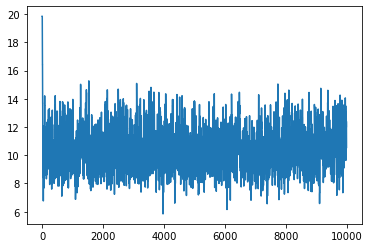

In [8]:
plt.plot(a)

In [9]:
# discard the first 1000 samples due to burn in
b = np.array(a[1000:])

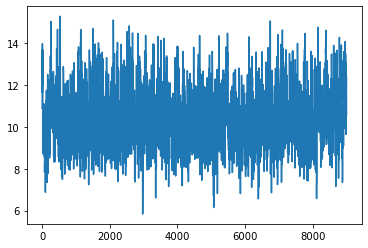

In [10]:
plt.plot(b)

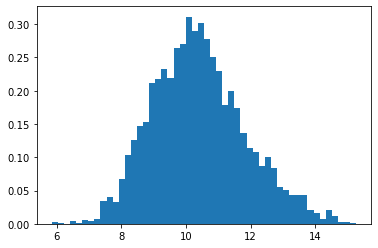

In [13]:
num_bins = 50
ppd_probs, bins, p = plt.hist(b, bins=num_bins, density=True)

The above histogram is a set of samples from the posterior, $p(h|d)$. It shows that the markov chain we constructed has a stationary distribution where the most likely value is 10 (the true parameter value).

Importantly this is a DISTRIBUTION for the value of the parameter. It reflects our uncertainty in it's value, rather than for example simply picking the most likely (maximum likelihood esimate).

Remember in real life, we never get to peak behind the scene at the generating process so this distribution of likely values is much more useful.

### Making predictions with the posterior predictive distribution

Having a distribution for the parameter value is great, but how do we actually make predictions with this data?

We use the posterior predictive distribution!

$$ p(y|x_{testpoint},d) = \int p(y|x_{testpoint},\theta) \times p(\theta|d) \,d \theta $$

This equation says that instead of using only a single estimate for the parameter value (as we would in MLE or MAP) we instead use all of them, summing up each estimation for the gradient and weighting it by the probability of observing it given the data.

This last quantity, the probability of the parameter given the data is what we've just spilled so much blood and treasure on!

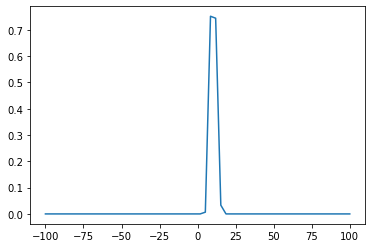

In [23]:
def predict_single_test_point(x_test):
    total_pdf = 0
    y_pdf_range = np.linspace(-100,100,60)
    for i in np.arange(num_bins):
        theta = bins[i]
        curr_pdf = norm.pdf(y_pdf_range,loc = theta*x_test,scale = 1)
        curr_pdf = curr_pdf*ppd_probs[i]
        total_pdf = total_pdf+curr_pdf
        
    return total_pdf

res = predict_single_test_point(1)

y_pdf_range = np.linspace(-100,100,60)
plt.plot(y_pdf_range,res)

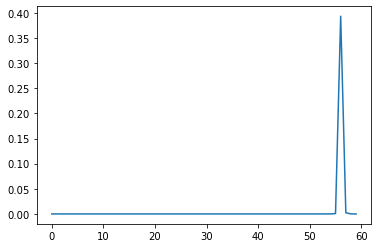

In [20]:
plt.plot(norm.pdf(y_pdf_range,loc = 9*10,scale = 1))

In [ ]:
def predict_grid_of_vals(x_test_space,num_evals_per_x_test):
    
    results_grid = np.zeros((num_evals_per_x_test,x_test_space.shape[0]))
    #results_grid = np.zeros((,x_test_space.shape[0],num_evals_per_x_test))
    
    
    for i in np.arange(x_test_space.shape[0]):
        x_test = predict_single_test_point(x_test_space[i])
        results_grid[:,i] = np.flip(x_test)
        
    return results_grid
    
x_test_space = np.linspace(-6,25,100)

res = predict_grid_of_vals(x_test_space,60)

#res = np.transpose(res)

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')
plt.imshow(res, interpolation='nearest')
plt.show()

## Gibbs sampling

### Data generation

In [ ]:
def generate_clusters(num_points):
    
    x_points = np.zeros(num_points)
    
    mu_1 = 5
    sigma_1 = 0.6
    
    mu_2 = 25
    sigma_2 = 1.5
    
    
    for i in np.arange(num_points):
        rand = np.random.uniform(low=0.0, high=1.0, size=1)[0]
    
        if rand>=0.5:
            sample =  np.random.normal(loc=mu_2, scale=sigma_2)
        else:
            sample =  np.random.normal(loc=mu_1, scale=sigma_1)
            
        x_points[i] = sample
    
    return x_points

# our gods eye view of the world
num_train_points = 2000

x_gibbs_data = generate_clusters(num_train_points)


plt.scatter(x_gibbs_data,np.zeros(num_train_points))
#plt.ylim([0, 50])